# 流程
##  目的: 對電影評論進行情感分析，結果爲positive或negative
##  方法: 『長短期記憶網路』(LSTM) 應用 -- 情緒分析(Sentiment Analysis)


## 先備知識:
* 影評事一段文字，是序列的，ＲＮＮ能夠記憶前文

## 步驟
* 資料預處理
    * 載檔案
    * 轉編碼(亂碼時，可以使用python的chardet類庫進行判斷)
    * 生成詞彙表
    * 轉詞向量 -> 每個單詞對應於一個編號，將影評資料轉化成詞向量。方便後面生成詞嵌入矩陣)
    * 統一長度-填充詞向量並轉化為np陣列(要組成batch進行訓練，就需要先將其長度統一。這裡我選擇以最長的影評為標準，對其他較短的影評的空白部分進行填充)
    * 劃分資料集(訓練集、測試集、驗證集)
    * 打亂資料集，寫入檔案(為了取得更好的訓練效果，將資料集隨機打亂)
    
* 建模
    * 使用embedding構建詞嵌入矩陣(一條影評，對應於一個由單詞編號構成的向量)，即可構建出詞嵌入矩陣。在詞嵌入矩陣中，每個詞由一個向量表示，矩陣中不同向量之間的差異對應於它們表示的詞之間的差異。
    * 使用LSTM作為迴圈神經網路的基本單元
    * 對embedding和LSTM進行隨機失活(dropout) -> 為了提高模型的泛化能力，並減少引數
    * 建立深度為2的深度迴圈神經網路 -> 為了提高模型的擬合能力
    * 給出二分類概率: 對深度迴圈神經網路的最後節點的輸出做邏輯迴歸，通過sigmoid使結果落到0-1之間，代表結果是正類的概率。
    * 損失函式使用交叉熵，優化器選擇Adam。

* 訓練(額外操作)
    * 使用移動平均 -> 使用的主要目的是使loss曲線儘量平滑，以及提升模型的泛化能力。
    ## ??
    * 使用學習率指數衰減 -> 目的是保證前期學習率足夠大，能夠快速降低loss，後期學習率變小，能更好地逼近最優解。


### 參考網站
1.https://www.twblogs.net/a/5b7ace622b7177392c96d970
2.https://www.itread01.com/article/1522031940.html

In [5]:
# 載入
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 實做

## 1.載入深度學習套件

In [6]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.datasets import imdb

In [7]:
from tensorflow.keras import *
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *

## 2.讀入數據

### ERROR: ValueError: Object arrays cannot be loaded when allow_pickle=False
* 主要是版本問題，當版本高於 1.16.2時，預設已經改為　allow_pickle=False
* Sol: np降版本　-> pip install numpy==1.16.2
* 記得要重開　Ｋｅｒｎｅｌ

In [8]:
pip install --user numpy==1.16.2

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install numpy==1.16.2

Note: you may need to restart the kernel to use updated packages.


In [30]:
# 載入數據
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000) #OKK了！
# num_words: 整数或 None。要考虑的最常用的词语
# 任何不太频繁的词将在序列数据中显示为 oov_char 值。 oov_char 值
# (補充))oov_char: 整数。由于 num_words 或 skip_top 限制而被删除的单词将被替换为此字符。

In [32]:
#觀察
print(type(x_train))
print(len(x_train), len(x_test))
print(len(y_train))

<class 'numpy.ndarray'>
25000 25000
25000


In [12]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [13]:
# 看第一個影評的長度
len(x_train[0])

218

In [14]:
# 影評長度不一
len(x_train[1]) == len(x_train[1996])

False

In [15]:
#ｙ代表影評正負向
y_train[0]

1

In [16]:
y_train[2000] #　負面

0

## 3.資料處理
### pad_sequences序列填充: 将多个序列截断或补齐为相同长度。
* 使用原因: 为了实现的简便，keras只能接受长度相同的序列输入
* 該方法: 该函数是将序列转化为经过填充以后的一个新序列。
* maxlen: 整数。最大序列长度。 任何更长的序列都将被截断。
    * 法一: 可指定序列統一的長度
    * 法二: 用最長序列的長度，其他短序列，則用默認的向前補值方法

In [78]:
#看原始資料最短和最長的影評
l = []
for i in x_train:
    l.append(len(x_train[i]))

print(min(l)) # 要在 for-loop 外
print(max(l))

# p=list.index(value)，p为value在list的位置
print(l.index(11)) #查影評長度為11的影評所在位置

11
2494
6719


In [79]:
print(x_train[6719]) # 的確只有11個字，一個字以一個數值表示

[1, 13, 586, 851, 14, 31, 60, 23, 2863, 2364, 314]


### 修改部分
* maxlen: 100 > 333
* epoch = 25 (因為有Early Stopping)
* batch = 66
* 把25000筆測試集拆成15000筆驗證集和10000筆測試集，此時訓練集、驗證集和測試集的比例為5:3:2

In [33]:
# 都切成一樣長，缺的補值
x_train = sequence.pad_sequences(x_train, maxlen = 333)
x_test = sequence.pad_sequences(x_test, maxlen=333)

In [34]:
print(x_train[6719]) # 已經補成長度為100
print(len(x_train[6719]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [35]:
# 訓練集、驗證集和測試集的比例為5:3:2
from sklearn.model_selection import train_test_split
x_val, x_test, y_val, y_test = train_test_split(x_test, 
                                                y_test,
                                                test_size = 0.4,
                                                random_state = 100)
print(x_val.shape, x_test.shape)
print(y_val.shape, y_test.shape)
print(x_train.shape, y_train.shape)

(15000, 333) (10000, 333)
(15000,) (10000,)
(25000, 333) (25000,)


In [36]:
import sklearn
x_train[1996]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [37]:
x_train.shape

(25000, 333)

## 4. step 01: 打造一個函數學習機
使用 Keras Sequential 顺序模型,顺序模型是多个网络层的线性堆叠
### 調整項目:
* LSTM改用GRU，並且降低神經元的數量(128增加150)
* Early Stopping

### 知識
1. Sequential序貫模型:
    * 是函式式模型的簡略版，為最簡單的線性、從頭到尾的結構順序，不分叉，是多個網路層的線性堆疊
    * Keras實現了很多層，包括core核心層，Convolution卷積層、Pooling池化層等非常豐富有趣的網路結構。
2. 神經網路的第一層 -> 將list型別轉換為tensor張量型別,才能送入神經網路中訓練，有兩種轉換方式：
    * Embedding層: 填充列表使每個列表長度都相同，然後轉換為整數型別的張量，形狀為(samples, word_indices)
    * 將列表進行one-hot編碼: 轉換成0、 1向量。然後用Dense網路層作為神經網路的第一層，處理浮點型別向量資料。
3. Embedding(max_features, output_dim)
    * Keras提供了一个嵌入层Embedding，适用于文本数据的神经网络。
    * 将正整数（索引值）转换为固定尺寸的稠密向量。 例如： [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
    * 该层只能用作模型中的第一层。
    * max_features=1000: 输入中最大的整数（即词索引）不应该大于 999 （词汇表大小）
    * output_dim: 词向量的维度,这是嵌入单词的向量空间的大小。它为每个单词定义了这个层的输出向量的大小。例如，它可能是32或100甚至更大
    * input_dim：这是文本数据中词汇的取值可能数。例如，如果您的数据是整数编码为0-9之间的值，那么词汇的大小就是10个单词
    * EX: 例如，下面我们定义一个词汇表为200的嵌入层（例如从0到199的整数编码的字，包括0到199），一个32维的向量空间，其中将嵌入单词，以及输入文档，每个单词有50个单词。
        * e = Embedding(input_dim=200, output_dim=32, input_length=50)


### 知識: 『嵌入』層:
* 是幫我們輸入的正整數轉為實數域上的向量，這是『詞嵌入』(Word Embedding)的技術，把一個維數為所有詞的數量的高維空間嵌入到一個維數低得多的連續向量空間中
* 每個單詞或詞組被映射為實數域上的向量。Google Tomas Mikolov 領導的團隊發明了一套工具『Word2Vec』來進行詞嵌入，訓練向量空間模型的速度比以往的方法都快

### 知識
4. model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
    * LSTM 模型常會造成過度擬合(Overfit)!! → 所以要有dropout & recurrent_dropout
    * 返回一個維度為128的向量
    * dropout: 針對 input 抑制過度擬合,即暂时从网络中移除神经网络中的单元,Dropout可以比较有效的缓解过拟合的发生，在一定程度上达到正则化的效果。避免模型「背答案」，每次學的時候該神經層有多少比例的參數不會去學習
    * 输入层0.2的 dropout 率适用于各种任务,隱藏層dropout 率設為0.5
    * recurrent：記憶過去的訓練輸出
    * recurrent_dropout: 針對上一個 output state 抑制過度擬合(hidden state的dropout)

In [38]:
# 基于 LSTM 的序列分類
model = Sequential()

# model.add(Embedding(max_features, output_dim))
model.add(Embedding(10000, 128))

# LSTM > GRU
#model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2)) 
model.add(GRU(64, dropout = 0.2, recurrent_dropout = 0.2))


# Dense
model.add(Dense(1, activation='sigmoid')) #1: output layer的單元，因輸出結果只有0或1(所以units=1)

# ??把model串在一起

In [39]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# adam好處：快、做momentum

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,317,121
Trainable params: 1,317,121
Non-trainable params: 0
_________________________________________________________________


In [41]:
#??
#(128+128+1)*4*128

### Early Stopping:
* 模型訓練一段時間後，當準確率不再有顯著的提升就提早結束訓練
* 能夠節省訓練的時間，也可防止過度擬合

In [42]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 0, mode = 'auto') 
    # patience = 4: 當模型不再有顯著的進步時，還會再多訓練3個epochs才結束訓練

## 5.step 02: 訓練
### 調整:
* batch_size 32 → 64
* epochs 10 → 25 (有實施early stopping，可以設高一點)

In [43]:
#model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

history = model.fit(x_train, y_train, batch_size = 64, epochs = 20, validation_data = (x_val, y_val), 
                    callbacks = [early_stopping])

Train on 25000 samples, validate on 15000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
25000/25000 [==============================] - 244s 10ms/sample - loss: 0.4962 - acc: 0.7593 - val_loss: 0.4683 - val_acc: 0.7855
Epoch 2/20
25000/25000 [==============================] - 248s 10ms/sample - loss: 0.3455 - acc: 0.8582 - val_loss: 0.3701 - val_acc: 0.8419
Epoch 3/20
25000/25000 [==============================] - 251s 10ms/sample - loss: 0.2979 - acc: 0.8800 - val_loss: 0.3413 - val_acc: 0.8584
Epoch 4/20
25000/25000 [==============================] - 248s 10ms/sample - loss: 0.2299 - acc: 0.9121 - val_loss: 0.3703 - val_acc: 0.8437
Epoch 5/20
25000/25000 [==============================] - 249s 10ms/sample - loss: 0.1923 - acc: 0.9285 - val_loss: 0.3470 - val_acc: 0.8577
Epoch 6/20
25000/25000 [==============================] - 249s 10ms/sample - loss: 0.1551 - acc: 0.9434 - val_loss: 0.3796 - val_acc: 0.8576
Epoch 7/20
25000/25000 [==============================] 

## 知識: Keras 儲存與載入訓練好的模型或參數
* `model.to_json()`: 以 JSON 字符串的形式返回模型的表示(※请注意:该表示不包括权重，仅包含结构)
    * 可以通过以下方式从 JSON 字符串重新实例化同一模型（使用重新初始化的权重）：
    * from keras.models import model_from_json

    * json_string = model.to_json()
    * model = model_from_json(json_string)
* `model.save_weights(filepath)`将模型权重存储为 HDF5 文件
* `model.load_weights(filepath, by_name=False)`: 从 HDF5 文件（由 save_weights 创建）中加载权重。默认情况下，模型的结构应该是不变的。 如果想将权重载入不同的模型（部分层相同）， 设置 by_name=True 来载入那些名字相同的层的权重。

## 6.訓練成果
訓練集和驗證集準確率和loss值的變化

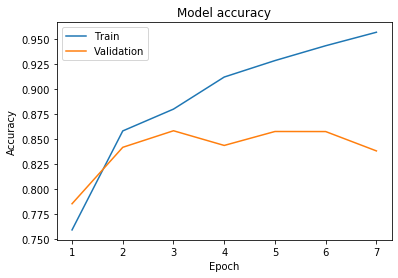

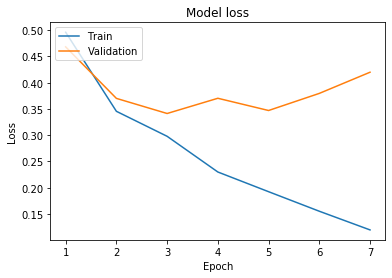

In [45]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(range(1, len(history.history['acc']) + 1), history.history['acc'])
plt.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 查看該模型預測測試集資料的結果

In [46]:
# 做出來的模型預測測試集的準確率為0.8471
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 12s 1ms/sample - loss: 0.4080 - acc: 0.8471
Test loss: 0.4080015291213989
Test accuracy: 0.8471


## 7.寫入檔案

In [47]:
model_json = model.to_json() #只儲存結構
open('imdb_model_architecture.json', 'w').write(model_json)
model.save_weights('imdb_model_weights.h5') #只存權重